# PyTorch Workflow

Explore an example PyTorch end to end workflow.

What this notebook covering:

1. Data preparing and loading
2. Building models
3. Fitting the model to data (training)
4. Making predictions and evaluating a model (inference)
5. Saving and loading a model
6. Putting it all together

https://pytorch.org/docs/stable/nn.html

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1'

## 1. Data (preparing and learning)

Data can be almost anything... in machine learning

Machine learning is a game of two parts:

1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representations

To showcase this, let's create some *known* data using the linear regression formula.
We'll use a linear regression formula to make a straight line with *known* **parameters**


In [3]:
# Create 'known' parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias

len(X), len(y)

(50, 50)

### Splitting data into training and test sets

Let's create a training and test set with our data

In [4]:
# Split the data into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## 2. Build model

In [5]:
class LinearRegressionModel(nn.Module): # Subclass nn.Module contains all the building blocks for neural networks
    def __init__(self):
        super().__init__()
        
        # Initialize model parameters   --    These could be different layers from torch.nn, single parameters, etc)
        self.weight = nn.Parameter(torch.rand(1,  # Modelin öğrenebilir parametreleri nn.Parameter ile tanımlanmalı
                                              requires_grad=True,  # Pytorch will keep track gradient of this for use with torch.autograd and gradient descent
                                              dtype=float))
        self.bias = nn.Parameter(torch.rand(1,
                                              requires_grad=True,  
                                              dtype=float))
    def forward(self, X: torch.Tensor) -> torch.Tensor:    # Any subclass of nn.Module needs to override forward() (this defines forward computation of the model)
        return self.weight * X + self.bias

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 


### Checking the contents of a PyTorch model

Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using .parameters().

In [6]:
import torch
from torch import nn
# Create a random seed
torch.manual_seed(42)

# Create a instance of a model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.0582], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.0629], dtype=torch.float64, requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.0582], dtype=torch.float64)),
             ('bias', tensor([0.0629], dtype=torch.float64))])

### Making predictions using `torch.inference_mode()`

To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

Let's make some predictions.




In [7]:
# Make predictions with model
with torch.inference_mode():
    y.preds = model_0(X_test)
y.preds 
# Results are very bad, since model is not trained

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)


tensor([[0.1094],
        [0.1106],
        [0.1118],
        [0.1129],
        [0.1141],
        [0.1152],
        [0.1164],
        [0.1176],
        [0.1187],
        [0.1199]], dtype=torch.float64)

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

You can directly use `y.preds = model_0(X_test)` but using `torch.inference_mode()` is more efficient

## 3. Train model

The whole idea of training is for a model to move from some *unknown* paramters (these may be random) to *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are: 

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another). 

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

And we'll use SGD, torch.optim.SGD(params, lr) where:

params is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).
lr is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).

In [8]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),   # parameters to optimize 
                      lr=0.01) # lr: learning rate



### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

Another explanations:

0. Loop through data
1. Forward pass (this involves data moving through our model's `forward()` function) to make predictions on data - also called forward propagations
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each parameters of our model with respect to the loss
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb: 
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* stepping them (`optimizer.step()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

For resources to help understand what's happening behind the scenes with backpropagation and gradient descent, see the extra-curriculum section.

In [9]:
# An epoch is one loop through the data... (this is a hyperparameter)
epochs = 1000 # an epoch refers to one complete pass through entire dataset

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set model to train mode (this is the default state of the model)
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
         
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default the optimizer changes will acumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
    
    
    ### Testing
    model_0.eval() # turns of different settings in the model not needed for evaluation/testing (dropout/batch norm layers, etc.)
    with torch.inference_mode(): # (turns of gradient tracking & a couple more things behind)
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} |  Loss: {loss} | Test Loss: {test_loss}") 
        
    
    
    

Epoch: 0 |  Loss: 0.48740957954762054 | Test Loss: 0.7948613474299793
Epoch: 10 |  Loss: 0.37219958028567507 | Test Loss: 0.6601513479001855
Epoch: 20 |  Loss: 0.25698958102372954 | Test Loss: 0.5254413483703916
Epoch: 30 |  Loss: 0.15880869663761565 | Test Loss: 0.40255174883521166
Epoch: 40 |  Loss: 0.11402923588994826 | Test Loss: 0.31734834924472094
Epoch: 50 |  Loss: 0.0956925529346293 | Test Loss: 0.26267344957748173
Epoch: 60 |  Loss: 0.08738441897884866 | Test Loss: 0.22768154985825237
Epoch: 70 |  Loss: 0.08259710290923128 | Test Loss: 0.20586695010039308
Epoch: 80 |  Loss: 0.07876590153399285 | Test Loss: 0.19077895030586509
Epoch: 90 |  Loss: 0.07527590166542106 | Test Loss: 0.17975895045912335
Epoch: 100 |  Loss: 0.07178590179684927 | Test Loss: 0.16873895061238167
Epoch: 110 |  Loss: 0.06831850502523909 | Test Loss: 0.15909275075797485
Epoch: 120 |  Loss: 0.06488270204802468 | Test Loss: 0.15082035089590293
Epoch: 130 |  Loss: 0.06144501523411564 | Test Loss: 0.14323485102

In [44]:
print(model_0.state_dict()) # Parameters are very close to the desired values

OrderedDict({'weight': tensor([0.6913], dtype=torch.float64), 'bias': tensor([0.2994], dtype=torch.float64)})


tensor([[0.8561],
        [0.8699],
        [0.8836],
        [0.8974],
        [0.9112],
        [0.9249],
        [0.9387],
        [0.9525],
        [0.9662],
        [0.9800]], dtype=torch.float64)


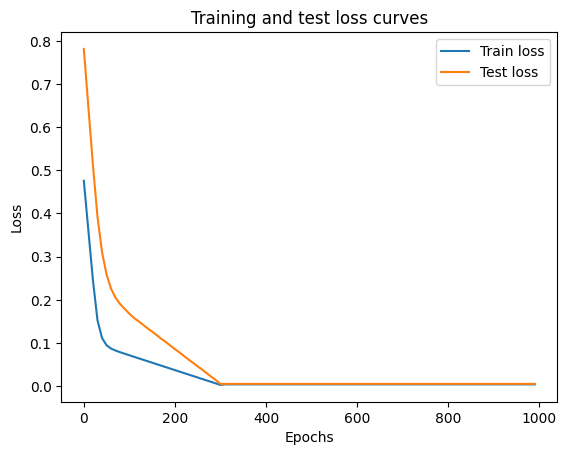

In [46]:
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Saving and loading a model

We're happy with our models predictions, so let's save it to file so it can be used later.

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.



In [42]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`? 

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by created another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [12]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [15]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model


# Putting all information together

In [17]:
# Import PyTorch
import torch
from torch import nn
print(torch.__version__)

2.2.1


In [18]:
# Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [19]:
# Create a dummy linear data
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [35]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

A `linear layer`, often referred to as a fully connected layer or dense layer in neural networks, applies a linear transformation to the incoming data. It does this by multiplying the input by a weight matrix and then adding a bias vector. This layer does not apply any *non-linearity* or *activation function* on its own; it simply computes linear transformation.

nn.Linear() her neuron'da sadece linear regresyon modeli kuran bir layer ekler. Eğer in_features ve out_features 1 olarak atanırsa, bunun tek bir input alıp tek bir çıktı dönen tek bir linear regresyon modelinden hiçbir farkı olmaz.

`Thanks to GPT`
Bir nöronun çıktısının vektör olması genel bir durum değildir; aslında, tek bir nöronun çıktısı genellikle tek bir skalar değerdir. Bir katmandaki birden fazla nöronun çıktıları bir araya geldiğinde bir vektör oluşturur, ancak her bir nöron kendi başına yalnızca bir skalar değer üretir. Bu nedenle, bir nöronun çıktısını vektör olarak düşünmek yerine, katman çıktılarını vektör veya matris olarak ele almak daha doğru olacaktır.

In [36]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict() # It will print random initial paramteter values

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [37]:
# Check model device
next(model_1.parameters()).device # cpu
model_1.to(device)
next(model_1.parameters()).device # mps(gpu)

device(type='mps', index=0)

In [38]:
# Create a loss function
loss_fn = nn.L1Loss()
# Create a optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [40]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Data and model should be on the same device (or error appear)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad optimizer
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()
    
    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train loss: 0.5436569452285767 | Test loss: 0.560505211353302
Epoch: 100 | Train loss: 0.0058781662955880165 | Test loss: 0.012984687462449074
Epoch: 200 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 300 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 400 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 500 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 600 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 700 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 800 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
Epoch: 900 | Train loss: 0.010256483219563961 | Test loss: 0.00033082367735914886
